In [4]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import sys
sys.path.append('..')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import scipy.stats as stats
import plotly.express as px
import urbanpy as up
import sklearn.metrics as metrics
from geopy import Nominatim
from matplotlib import rcParams
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import tqdm
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from ipywidgets import interact, Dropdown, FloatSlider, IntSlider
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

Cargamos el csv limpio

In [240]:
df=pd.read_csv('https://raw.githubusercontent.com/Jhovanylara/Land-Prices-at-Mexico-City/master/Datasets/ETL.csv')

Quitamos columnas que no vamos a entrenar

In [191]:
df.drop(columns=['hospital_near','pharmacy_near','clinic_near','dentist_near','doctors_near','convenience_near','supermarket_near','school_near','university_near','kindergarten_near','bank_near', 'atm_near', 'butcher_near', 'greengrocer_near', 'mall_near', 'marketplace_near'], inplace=True)

Quitamos filas con datos faltantes

In [192]:
missing_cost=df.loc[df['target']==0] #Hacemos un dataframe solo con los costos vacíos
df['target'].replace(0,np.nan, inplace=True) #Reemplazamos por NaN
df=df.dropna(subset="target") #Eliminamos las filas con datos faltantes

Hacemos un mapa de calor

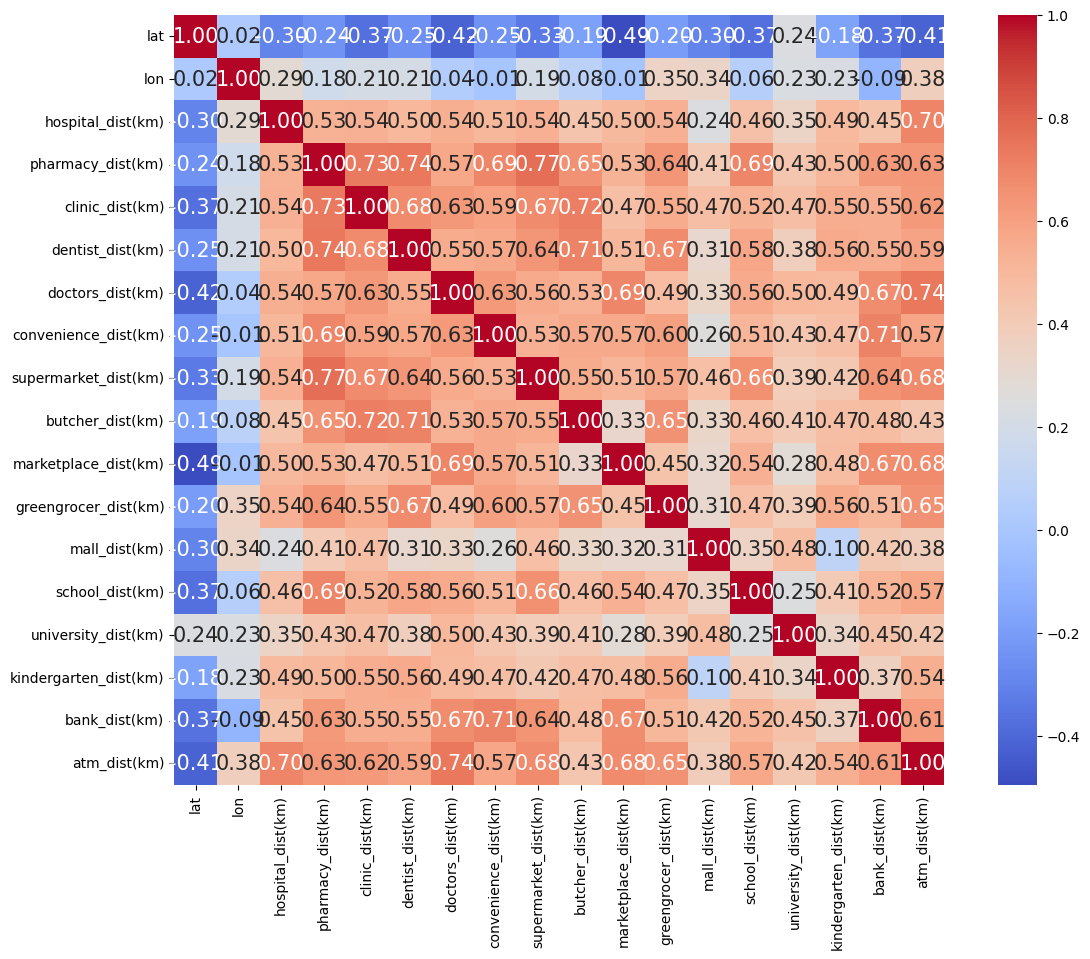

In [8]:
corr = df.drop(columns = ['target']).corr(method='pearson')
plt.figure(figsize=(14,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= df.drop(columns = ['target']).columns, 
           yticklabels= df.drop(columns = ['target']).columns,
           cmap= 'coolwarm')

plt.show()

Quitamos Outliers

In [193]:
#Obtenemos df sin colonia ni Alcaldia
X=df.iloc[:,2:]


In [194]:
list=[]
for col in X.columns:
    list.append(col)
list.remove('lat')
list.remove('lon')

df_Limpieza = X
print(f'Tamaño muestra: {len(df_Limpieza)}')

filtro1 = np.array([True] * len(df_Limpieza))

for col in list:
    zscore = abs(stats.zscore(df_Limpieza[col])) 
    filtro1 = (zscore < 2) & filtro1  #PONEMOS UN FILTRO DE ZSCORE >= 2
    
df_SinOutliers = df_Limpieza[filtro1] 

print(f'Total Outliers: {len(df_Limpieza)-len(df_SinOutliers)}')
print(f'Muestra sin Outliers: {len(df_SinOutliers)}')

Tamaño muestra: 678
Total Outliers: 143
Muestra sin Outliers: 535


Dividimos el dataset para entrenamiento y testeo

In [195]:
X=df_SinOutliers.iloc[:,:-1]
y=df_SinOutliers.iloc[:,-1]

In [196]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=0)

In [197]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean m2 price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean m2 price: 31034.36539222747
Baseline MAE: 8984.656590374294


In [198]:
# Build Model
model = make_pipeline(
        #OneHotEncoder(),
        #SimpleImputer(),
        HuberRegressor()
)
# Fit model
model.fit(X_train, y_train)

C:\Users\Jhovany Lara\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Pipeline(steps=[('huberregressor', HuberRegressor())])

In [199]:
#Predict
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.shape

(81,)

In [167]:
def predict_price(latitude, longitud):

    mx=up.download.nominatim_osm('Ciudad de Mexico, Mexico')
    cdmx=pd.DataFrame({'lat':latitude,'lon':longitud}, index=[0])
    
    #Cargamos datos de salud
    es=up.download.overpass_pois(bounds=mx.total_bounds, facilities='health')
    health=['hospital', 'pharmacy','clinic', 'dentist', 'doctors']
    for i in health:
        z=es[es['poi_type']==i]
        dist_up, ind_up=up.utils.nn_search(
            tree_features=z[['lat','lon']].values,#Puntos de interes
            query_features=cdmx[['lat','lon']].values,#coordenadas de cada colonia
            metric='haversine' #Metrica de distancia
        )
        cdmx[f'{i}_dist(km)']=dist_up

    #Cargamos datos de alimentos
    es=up.download.overpass_pois(bounds=mx.total_bounds, facilities='food')
    food=['convenience', 'supermarket','butcher', 'marketplace', 'greengrocer','mall']

    for i in food:
        z=es[es['poi_type']==i]
        dist_up, ind_up=up.utils.nn_search(
            tree_features=z[['lat','lon']].values,#Puntos de interes
            query_features=cdmx[['lat','lon']].values,#coordenadas de cada colonia
            metric='haversine' #Metrica de distancia
        )
        cdmx[f'{i}_dist(km)']=dist_up

    #Cargamos datos de educación
    es=up.download.overpass_pois(bounds=mx.total_bounds, facilities='education')
    education=['school', 'university','kindergarten']

    for i in education:
        z=es[es['poi_type']==i]
        dist_up, ind_up=up.utils.nn_search(
            tree_features=z[['lat','lon']].values,#Puntos de interes
            query_features=cdmx[['lat','lon']].values,#coordenadas de cada colonia
            metric='haversine' #Metrica de distancia
        )
        cdmx[f'{i}_dist(km)']=dist_up

    #Cargamos datos financieros
    es=up.download.overpass_pois(bounds=mx.total_bounds, facilities='finance')
    finance=['bank', 'atm']

    for i in finance:
        z=es[es['poi_type']==i]
        dist_up, ind_up=up.utils.nn_search(
            tree_features=z[['lat','lon']].values,#Puntos de interes
            query_features=cdmx[['lat','lon']].values,#coordenadas de cada colonia
            metric='haversine' #Metrica de distancia
        )
        cdmx[f'{i}_dist(km)']=dist_up
    #return cdmx
    prediction = model.predict(cdmx).round(2)
    return f"Predicted m2 price: ${prediction}"

In [89]:
predict_price(19.510893, -99.144619)

'Predicted m2 price: $[23029.89]'

Completing missing values in dataframe

In [200]:
missing_cost.head()

,Colonia,Alcaldía,lat,lon,hospital_dist(km),pharmacy_dist(km),clinic_dist(km),dentist_dist(km),doctors_dist(km),convenience_dist(km),...,butcher_dist(km),marketplace_dist(km),greengrocer_dist(km),mall_dist(km),school_dist(km),university_dist(km),kindergarten_dist(km),bank_dist(km),atm_dist(km),target
678,ZONA MILITAR FAVE SEDENA (U HAB),IZTAPALAPA,19.311541,-99.083730,0.194075,0.400604,3.593563,0.809835,4.689416,0.304098,...,0.408307,2.008145,0.682601,5.780888,2.620470,4.526333,2.726178,0.869720,5.899051,0.0
679,VILLA QUIETUD (FRACC),COYOACAN,19.304565,-99.105070,2.519629,0.560905,3.066734,1.839109,2.421418,0.512743,...,2.085977,1.373374,2.345891,6.883592,0.597224,3.862146,2.151237,2.126201,3.873867,0.0
680,VILLA PANAMERICANA 3ERA. SECCIN (U HAB),COYOACAN,19.307900,-99.172468,1.350076,0.149845,0.523357,0.187647,0.192354,0.408843,...,0.176506,0.415676,1.165744,4.097592,1.563323,1.087965,2.112550,0.611209,0.707220,0.0
681,VERTIZ NARVARTE,BENITO JUAREZ,19.381628,-99.153719,1.239247,0.179204,0.729521,0.900390,1.437742,0.112804,...,0.736846,1.029307,0.778324,3.309321,0.264366,0.857782,1.320151,0.393947,0.932178,0.0
682,VENUSTIANO CARRANZA (AMPL),VENUSTIANO CARRANZA,19.444105,-99.104934,1.226957,0.189542,1.680384,3.127216,1.149898,1.039910,...,0.997530,1.170111,2.616114,1.269641,0.640249,5.529269,2.771041,0.689232,3.050369,0.0


In [169]:
print ('antes', missing_cost.shape)
missing_cost=missing_cost.dropna()
print ('despues', missing_cost.shape)

antes (180, 21)
despues (180, 21)


Completamos los valores faltantes en costo/m2 con predicciones

In [201]:
missing=missing_cost.iloc[:,2:]
missing

,lat,lon,hospital_dist(km),pharmacy_dist(km),clinic_dist(km),dentist_dist(km),doctors_dist(km),convenience_dist(km),supermarket_dist(km),butcher_dist(km),marketplace_dist(km),greengrocer_dist(km),mall_dist(km),school_dist(km),university_dist(km),kindergarten_dist(km),bank_dist(km),atm_dist(km),target
678,19.311541,-99.083730,0.194075,0.400604,3.593563,0.809835,4.689416,0.304098,0.817598,0.408307,2.008145,0.682601,5.780888,2.620470,4.526333,2.726178,0.869720,5.899051,0.0
679,19.304565,-99.105070,2.519629,0.560905,3.066734,1.839109,2.421418,0.512743,2.154928,2.085977,1.373374,2.345891,6.883592,0.597224,3.862146,2.151237,2.126201,3.873867,0.0
680,19.307900,-99.172468,1.350076,0.149845,0.523357,0.187647,0.192354,0.408843,0.212955,0.176506,0.415676,1.165744,4.097592,1.563323,1.087965,2.112550,0.611209,0.707220,0.0
681,19.381628,-99.153719,1.239247,0.179204,0.729521,0.900390,1.437742,0.112804,0.510557,0.736846,1.029307,0.778324,3.309321,0.264366,0.857782,1.320151,0.393947,0.932178,0.0
682,19.444105,-99.104934,1.226957,0.189542,1.680384,3.127216,1.149898,1.039910,0.577666,0.997530,1.170111,2.616114,1.269641,0.640249,5.529269,2.771041,0.689232,3.050369,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,19.402220,-99.077949,2.077254,0.761217,1.555856,1.678783,1.654201,0.212476,1.760984,1.573789,1.915708,1.678751,4.519099,1.270820,1.565890,1.532572,0.687251,2.167467,0.0
854,19.369901,-99.178427,0.348693,0.402571,2.120859,0.915184,0.651160,0.183456,0.659580,2.108131,0.548050,1.006011,2.368388,0.643761,1.044131,2.381655,0.272007,1.249524,0.0
855,19.443236,-99.114841,1.000014,0.288363,0.672203,2.932061,0.601796,0.276825,0.981329,0.706764,1.022248,2.781967,1.423573,0.128329,4.637980,1.782714,0.489317,2.433791,0.0
856,19.448867,-99.209112,0.642178,0.905279,1.149388,2.994904,1.827186,0.580187,0.471014,2.403546,1.925003,2.374877,1.144356,0.543641,5.276639,2.638372,0.062848,0.917545,0.0


In [202]:
n=678
for i in range(0,len(missing)-1):
    #Creamos un dataframe con la fila a predecir
    a=missing.iloc[i]
    df22=pd.DataFrame(a)
    df22=df22.T
    df22=df22.drop(['target'], axis=1)
    
    prediction = model.predict(df22).round(2)
    if prediction[0] < 0:
        prediction=np.array([1272.79])
    missing.at[n,'target']=prediction[0]
    n+=1

In [172]:
missing.head()

,lat,lon,hospital_dist(km),pharmacy_dist(km),clinic_dist(km),dentist_dist(km),doctors_dist(km),convenience_dist(km),supermarket_dist(km),butcher_dist(km),marketplace_dist(km),greengrocer_dist(km),mall_dist(km),school_dist(km),university_dist(km),kindergarten_dist(km),bank_dist(km),atm_dist(km),target
678,19.311541,-99.083730,0.194075,0.400604,3.593563,0.809835,4.689416,0.304098,0.817598,0.408307,2.008145,0.682601,5.780888,2.620470,4.526333,2.726178,0.869720,5.899051,18366.13
679,19.304565,-99.105070,2.519629,0.560905,3.066734,1.839109,2.421418,0.512743,2.154928,2.085977,1.373374,2.345891,6.883592,0.597224,3.862146,2.151237,2.126201,3.873867,21425.26
680,19.307900,-99.172468,1.350076,0.149845,0.523357,0.187647,0.192354,0.408843,0.212955,0.176506,0.415676,1.165744,4.097592,1.563323,1.087965,2.112550,0.611209,0.707220,38346.65
681,19.381628,-99.153719,1.239247,0.179204,0.729521,0.900390,1.437742,0.112804,0.510557,0.736846,1.029307,0.778324,3.309321,0.264366,0.857782,1.320151,0.393947,0.932178,35125.92
682,19.444105,-99.104934,1.226957,0.189542,1.680384,3.127216,1.149898,1.039910,0.577666,0.997530,1.170111,2.616114,1.269641,0.640249,5.529269,2.771041,0.689232,3.050369,28785.84


In [203]:
missing_cost['target']=missing['target']

In [204]:
missing_cost['target'].replace(0,np.nan, inplace=True) #Reemplazamos por NaN
missing_cost=missing_cost.dropna(subset="target") #Eliminamos las filas con datos faltantes

In [205]:
missing_cost['target'].value_counts()

1272.79     4
18366.13    1
33877.18    1
43428.40    1
28217.21    1
           ..
38515.58    1
29863.77    1
25641.28    1
44171.66    1
29790.55    1
Name: target, Length: 176, dtype: int64

In [206]:
missing_cost.sort_values(by=['target'])

,Colonia,Alcaldía,lat,lon,hospital_dist(km),pharmacy_dist(km),clinic_dist(km),dentist_dist(km),doctors_dist(km),convenience_dist(km),...,butcher_dist(km),marketplace_dist(km),greengrocer_dist(km),mall_dist(km),school_dist(km),university_dist(km),kindergarten_dist(km),bank_dist(km),atm_dist(km),target
769,LA CONCHITA I,TLAHUAC,19.288295,-99.039527,5.207410,1.367187,5.843655,2.968307,9.005776,2.301918,...,4.012828,5.783065,4.022965,6.914845,1.769134,8.119682,5.357195,1.347633,9.426546,1272.79
708,SAN MIGUEL TOPILEJO (PBLO),TLALPAN,19.199794,-99.147456,0.727340,4.989947,10.288500,8.007231,9.030567,4.528122,...,9.780353,7.449265,6.584463,14.623423,0.620481,9.407648,5.589987,6.972892,7.998628,1272.79
718,SAN FRANCISCO TLALTENCO (PBLO),TLAHUAC,19.305469,-99.013419,5.901867,3.168960,6.141039,5.317754,6.377904,2.085572,...,6.121436,7.943203,6.631528,4.673438,3.102234,7.657143,8.189294,3.180561,10.665054,1272.79
694,SANTIAGO ZAPOTITLAN (PBLO),TLAHUAC,19.306864,-99.031141,5.381991,1.308830,4.605696,3.488177,7.609356,1.721514,...,4.495944,6.670473,4.814356,4.680474,1.281089,6.987576,6.463972,1.477863,10.789686,1272.79
811,DESARROLLO URBANO QUETZALCOATL II,IZTAPALAPA,19.328433,-99.042655,4.508195,1.573908,2.204684,3.711521,4.964622,1.447741,...,2.214510,4.008598,4.738730,3.286165,1.394084,4.500655,4.462948,1.570065,8.912142,6899.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764,LOMAS DEL CHAMIZAL,CUAJIMALPA DE MORELOS,19.393779,-99.263531,1.491651,0.431824,2.517549,3.199519,4.114987,0.565178,...,0.625425,3.481762,0.629038,0.371851,3.222777,2.995472,3.863846,1.279671,2.111905,41818.24
794,FLOR DE MARIA,ALVARO OBREGON,19.350179,-99.204447,1.194762,0.322219,3.746909,3.144213,1.245214,1.150880,...,4.562794,1.373219,3.379391,1.219046,1.452924,2.096544,2.881373,1.076271,1.666830,43428.40
744,PASEO DE LAS LOMAS-SAN GABRIEL,ALVARO OBREGON,19.378439,-99.254683,0.496316,0.491589,1.826173,3.697061,3.779473,0.484927,...,1.367740,1.573519,1.366144,0.206441,1.907215,1.386131,3.319291,0.107899,0.170244,44171.66
780,INDEPENDENCIA BATAN SUR (U HAB),LA MAGDALENA CONTRERAS,19.333104,-99.211689,1.190583,0.418890,4.373713,2.835764,1.310692,1.212386,...,4.723335,1.021420,2.784061,1.649433,1.074137,1.562105,3.535833,0.678596,1.023720,44632.19


In [207]:
df=pd.concat([df,missing_cost])

In [208]:
df.shape

(857, 21)

In [ ]:
df.to_csv('CDMXpredicted.csv', index=False)

In [247]:
hoy=pd.read_csv('CDMXcomplete.csv')

In [248]:
hoy.sort_values(by=['target'])

,Colonia,Alcaldía,lat,lon,hospital_dist(km),pharmacy_dist(km),clinic_dist(km),dentist_dist(km),doctors_dist(km),convenience_dist(km),...,butcher_dist(km),marketplace_dist(km),greengrocer_dist(km),mall_dist(km),school_dist(km),university_dist(km),kindergarten_dist(km),bank_dist(km),atm_dist(km),target
169,SAN FRANCISCO TLALNEPANTLA (PBLO),XOCHIMILCO,19.200127,-99.121855,1.968018,3.915443,10.684269,7.476445,9.944705,2.142674,...,10.452663,6.379622,6.386271,16.014920,2.099471,10.243763,6.870695,7.385853,7.686999,3.000000
599,CAPULTITLAN,GUSTAVO A. MADERO,19.479008,-99.133061,0.505898,0.301560,1.285799,1.251039,0.853141,0.327120,...,3.116324,0.933249,1.270567,4.085731,0.391071,5.413482,0.560393,0.999101,1.288776,84.000000
656,AGRICULTURA,MIGUEL HIDALGO,19.450810,-99.165317,0.432725,0.595523,1.817019,1.324927,0.974890,0.465919,...,3.509912,0.614566,1.109081,3.005240,0.402431,1.728244,0.489458,0.814524,0.854509,299.000000
769,LA CONCHITA I,TLAHUAC,19.288295,-99.039527,5.207410,1.367187,5.843655,2.968307,9.005776,2.301918,...,4.012828,5.783065,4.022965,6.914845,1.769134,8.119682,5.357195,1.347633,9.426546,1272.790000
718,SAN FRANCISCO TLALTENCO (PBLO),TLAHUAC,19.305469,-99.013419,5.901867,3.168960,6.141039,5.317754,6.377904,2.085572,...,6.121436,7.943203,6.631528,4.673438,3.102234,7.657143,8.189294,3.180561,10.665054,1272.790000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,CONDESA,CUAUHTEMOC,19.414898,-99.176034,0.597796,0.141850,0.442557,1.240929,1.539732,0.141399,...,1.620545,1.896776,1.185513,2.194583,0.293926,1.714235,1.143478,0.395281,0.220303,63308.575000
550,DEL CARMEN,COYOACAN,19.353470,-99.165582,0.734314,0.325019,0.880716,1.270632,0.545543,0.240337,...,1.021202,1.745913,1.027407,1.840867,0.444660,1.473132,1.777611,0.271314,0.320842,64041.244444
461,HIPODROMO CONDESA,CUAUHTEMOC,19.409805,-99.179079,1.228287,0.480522,0.994907,1.208047,1.249695,0.210302,...,1.826082,1.283680,1.834374,2.483987,0.917121,2.134406,1.643320,0.302015,0.452148,64430.721311
39,TORRES LINDAVISTA (FRACC),GUSTAVO A. MADERO,19.511129,-99.142788,0.627445,0.247550,0.475763,0.743254,0.883687,0.246966,...,0.854619,2.966235,0.766929,7.363229,0.498572,5.925902,1.816241,0.614070,0.784529,65102.000000


In [6]:
s="16.2000, -19.200"
ls=s.split(",")


['16.2000', ' -19.200']

In [8]:
lat=ls[0]
lon=ls[1]
lat, lon

'16.2000'